In [1]:
from collections import OrderedDict
 
class LRUCache:
    def __init__(self, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity
        self.stats = []
 
    def get(self, key: int) -> int:
        if key not in self.cache:
            self.stats.append(0)
            return -1
        else:
            self.stats.append(1)
            self.cache.move_to_end(key)
            return self.cache[key]
 
    def put(self, key: int, value: int) -> None:
        self.cache[key] = value
        self.cache.move_to_end(key)
        if len(self.cache) > self.capacity:
            self.cache.popitem(last = False)

In [2]:
import os.path as osp
import os
import torch
from overflowDataset import OpenFlowDataset
from tqdm import tqdm
from neighbor_sampler import NeighborSampler

__file__ = os.path.abspath('')
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'OpenFlow')

print("Loading dataset...")
dataset = OpenFlowDataset(path)
data = dataset[0]
#data.n_id = torch.arange(data.num_nodes)

Loading dataset...


In [3]:
data

Data(x=[63497050, 128], edge_index=[2, 63497050], edge_attr=[63497050])

In [9]:
len(torch.unique(data.edge_index[0]))

2226243

In [23]:
subset

634970

In [22]:
total_nodes/10

452290.9

In [10]:
len(torch.unique(data.edge_index[1]))

2296666

In [5]:
subset = int(data.num_nodes / 100)
total_nodes = torch.unique(data.edge_index[0]).numel() + torch.unique(data.edge_index[1]).numel()
# Assume CPU cache is 5% of data
CPUCacheNum = int(total_nodes / 10)

# Assume GPU cache is 0.25% of data
GPUCacheNum = int(total_nodes / 200)
node_ids = torch.flatten(data.edge_index.t())

CPUCache  = LRUCache(CPUCacheNum)
GPUCache = LRUCache(GPUCacheNum)

temp_loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=node_ids[:subset*2], batch_size=2)

pbar = tqdm(total=subset*2)
for batch_size, ids, adjs in temp_loader:
  for i in ids:
    i = int(i)
    val = CPUCache.get(i)
    if (val == -1):
      # Fetch from SSD
      CPUCache.put(i,i)
  pbar.update(batch_size)
pbar.close()

100%|██████████| 1269940/1269940 [06:24<00:00, 3302.32it/s]


In [6]:
def sum_intervals(vals):
    interval_size = 20000
    num_intervals = len(vals) // interval_size
    interval_sums = []
    for i in range(num_intervals):
        start_index = i * interval_size
        end_index = start_index + interval_size
        interval = vals[start_index:end_index]
        interval_sum = sum(interval) / interval_size
        interval_sums.append(interval_sum)
    return interval_sums

def getHitRate(stats):
    return sum(stats)/len(stats)

In [7]:
stats = list(CPUCache.stats)
intervals_dynamic = sum_intervals(stats)
getHitRate(intervals_dynamic)

0.9420580034423398

Text(0.5, 0, 'Iterations')

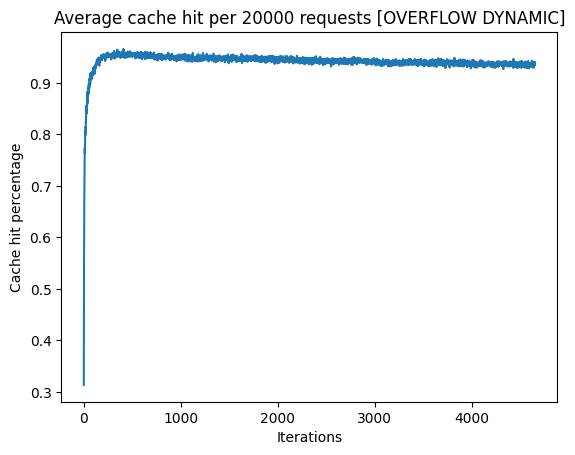

In [26]:
import matplotlib.pyplot as plt

plt.plot(intervals_dynamic)
plt.title('Average cache hit per 20000 requests [OVERFLOW DYNAMIC]')
plt.ylabel('Cache hit percentage')
plt.xlabel('Iterations')

In [9]:
import scipy
import numpy as np

coo = data.edge_index.numpy()
v = np.ones_like(coo[0])
coo = scipy.sparse.coo_matrix((v, (coo[0], coo[1])), shape=(data.num_nodes, data.num_nodes))
csc = coo.tocsc()
csr = coo.tocsr()

csc_indptr_tensor = torch.from_numpy(csc.indptr.astype(np.int64))
csr_indptr_tensor = torch.from_numpy(csr.indptr.astype(np.int64))
out_num_neighbors = csr_indptr_tensor[1:] - csr_indptr_tensor[:-1]
in_num_neighbors = (csc_indptr_tensor[1:] - csc_indptr_tensor[:-1])


In [10]:
sorted_vals_out, indices_out = torch.sort(out_num_neighbors, descending=True)
sorted_vals_in, indices_in = torch.sort(in_num_neighbors, descending=True)

In [11]:
print(sorted_vals_in)
print(indices_in)

tensor([22258, 14743, 12732,  ...,     0,     0,     0])
tensor([   22656,  1144035,    29407,  ..., 22696800, 22696801, 22696802])


In [12]:
csc_indptr_tensor.numel()

63497051

In [13]:
torch.unique(csc_indptr_tensor).numel()

2296667

In [14]:
# Sanity check in/out neighbours correct

nds = torch.tensor([22656, 1144035], dtype=torch.long)
temp_loader = NeighborSampler(data.edge_index, sizes=[-1], node_idx=nds, batch_size=1)
for batch_size, ids, adjs in temp_loader:
    print(ids.size())

torch.Size([22258])
torch.Size([14743])


In [15]:
subset = int(data.num_nodes / 100)
node_ids = torch.flatten(data.edge_index.t())

# Assume CPU cache is 20% of data
CPUCache  = LRUCache(int(total_nodes/10))

# Assume GPU cache is 0.5% of data
GPUCache = LRUCache(int(total_nodes/200))

# Populate cache with highest out degree nodes
for i in range(int(subset/10)):
    val = int(indices_out[i])
    CPUCache.put(val, val)

In [16]:
temp_loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=node_ids[:subset*2], batch_size=2)

pbar = tqdm(total=subset*2)
for batch_size, ids, adjs in temp_loader:
  for i in ids:
    i = int(i)
    val = CPUCache.get(i)
  pbar.update(batch_size)
pbar.close()

100%|██████████| 1269940/1269940 [06:03<00:00, 3491.47it/s]


In [17]:
static_stats = CPUCache.stats
intervals_static = sum_intervals(static_stats)

(0.5, 1.0)

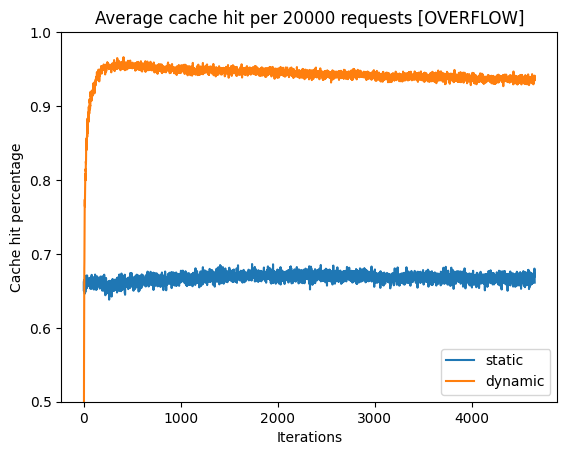

In [28]:
import matplotlib.pyplot as plt

plt.plot(intervals_static, label="static")
plt.plot(intervals_dynamic, label="dynamic")
plt.legend()
plt.title('Average cache hit per 20000 requests [OVERFLOW]')
plt.ylabel('Cache hit percentage')
plt.xlabel('Iterations')
plt.ylim([0.5,1])

In [20]:
sum(static_stats)/len(static_stats)

0.6430531510972097

In [ ]:
# We find poor results if we use static caching. Perhaps this is due to the dataset used. Can we find a way to quantify the graph structure?

In [10]:
len(edges[:2*subset])

1269940

In [13]:
edges = data.edge_index.t()
dic_temp = {}
for i in range(len(edges[len(edges) - 2*subset:])):
    src = int(edges[i][0])
    dst = int(edges[i][1])
    tup = (src, dst)
    if src in dic_temp:
        dic_temp[src] += 1
    else:
        dic_temp[src] = 1
    
    if dst in dic_temp:
        dic_temp[dst] += 1
    else:
        dic_temp[src] = 1
    


In [14]:
len(dic_temp)

73570

In [8]:
# Percentage of all edges that are repeated
edges = data.edge_index.t()
dic = {}
for i in range(len(edges)):
    src = int(edges[i][0])
    dst = int(edges[i][1])
    tup = (src, dst)
    if tup in dic:
        dic[tup] += 1
    else:
        dic[tup] = 1


# We hypothesise 

In [57]:
# Number of unique edges
len(dic)

36233450

In [9]:
edge_repeats = dic.values()

In [62]:
edge_repeats = list(edge_repeats)

In [10]:
only_ones = [i for i in edge_repeats if i==1]
not_start = [i for i in edge_repeats if i !=1 and i !=2 and i!=3]
only_twos = [i for i in edge_repeats if i==2]
only_threes = [i for i in edge_repeats if i==3]

In [13]:
sum(only_ones) + sum(only_twos) + sum(only_threes)

42213961

In [12]:
sum(not_start)

21283089

In [64]:
len(only_ones)

28199827

In [77]:
len(only_twos)

4623594

In [82]:
len(only_threes)

1588982

In [84]:
len(not_start)

1821047

(0.0, 250.0)

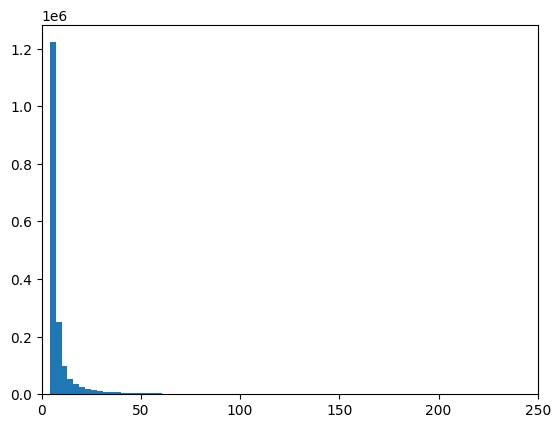

In [85]:
plt.hist(not_start, 10000)
plt.xlim([0,250])

In [28]:
t = torch.load('LRU_subset_1.0Ccache_10.pt')
t = list(t)

intervals_dynamic = sum_intervals(t)
getHitRate(intervals_dynamic)

tensor(0.5105)

Text(0.5, 0, 'Iterations')

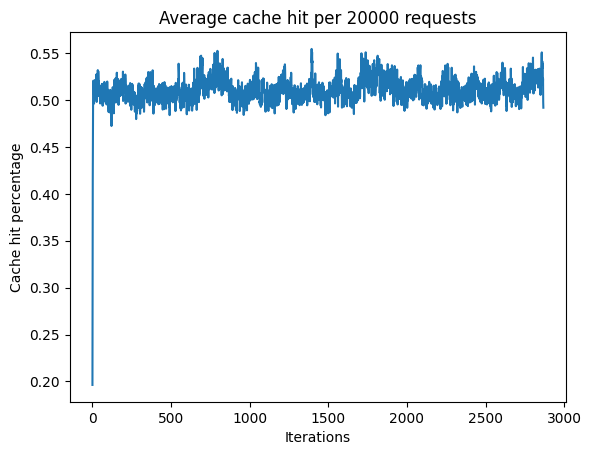

In [29]:
import matplotlib.pyplot as plt

plt.plot(intervals_dynamic)
plt.title('Average cache hit per 20000 requests')
plt.ylabel('Cache hit percentage')
plt.xlabel('Iterations')

In [7]:
# For LRU
cacheSizes = [10,20,40,60,80]
LRU_hits = [51.05, 63.94, 77.08, 84.17, 88.67]

# For static
static_hits = [55.36, 66.03, 76.79, 82.93, 87.09]

In [31]:
t = torch.load('static_subset_1.0Ccache_10.pt')
sum(t)